In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import trajectory_processor
import numpy as np
import matplotlib.pyplot as plt
import util
import mechanism
import planar_isotropic_mechanism_with_policy_graph
import joblib
import matplotlib.pyplot as plt

path_trans_mat = "../temp/TransMat_4thRing.txt" 
def perturb_trajectory(traj, traj_processor, delta, epsilon, mec, graph_mat, iter_num=20):
    reports = {"trajectories": [], "distance": [], "DoP": []}
    traj_processor.load(path_trans_mat, query)
    traj_processor.modify_for_test_traj(traj)
    
    for _ in range(iter_num):
        
        prior_distribution = np.zeros(traj_processor.size)
        prior_distribution[traj[0]] = 1
        perturbed_trajectory = np.zeros((len(traj) ,2))
        distances = []
        dops = []

        for i, traj_ in enumerate(traj):
            #print("true state:", np.where(oh_loc==1)[0][0])
            print(f"time_stamp: {i}", end="\t")
            print(traj_)

            pos_dist = traj_processor.compute_posterior_distribution(prior_distribution)
            state_nos = traj_processor.compute_possible_set(pos_dist, delta=delta)

            coords = traj_processor.state2loc(state_nos)
            true_loc = traj_processor.state2loc(np.array([traj_]))[0]
            
            if graph_mat is None:
                mec.load(coords, state_nos)
            else:
                mec.load(coords, state_nos, graph_mat)
                
            mec.build_distribution(epsilon)
            perturbed_loc = mec.perturb(true_loc)
            perturbed_trajectory[i,:] = perturbed_loc
            
            #print("true:", true_loc, "perturbed_loc", perturbed_loc)
            prior_distribution = mec.inference(pos_dist, perturbed_loc)

            error = np.linalg.norm(true_loc - perturbed_loc)
            distances.append(error * 0.34)
            
            dop = mec.n_is_in(mec.surrogated)
            dops.append(dop)
            
        reports["trajectories"].append(perturbed_trajectory)
        reports["distance"].append(distances)
        reports["DoP"].append(dops)
        
    return reports

def perturb_trajs(trajs, traj_processor, delta, epsilon, mec, graph_mat, iter_num=1):
    reports = []
    for traj in trajs:
        reports.append(perturb_trajectory(traj[:101], traj_processor, delta, epsilon, mec, graph_mat, iter_num))
    return reports

def compute_ave_reports(reports):
    ave_distance = np.average([report["distance"] for report in reports], axis=0)[0]
    ave_DoP = np.average([report["DoP"] for report in reports], axis=0)[0]
    
    return ave_distance, ave_DoP

In [2]:
query = np.loadtxt("../temp/locQuery.txt")

data = "../temp/testTrajSet_4thRing.txt"
trajs = pd.read_csv("../temp/TestTrajSet_4thRing.txt", header=None).to_numpy()

epsilon = 1

traj_processor = trajectory_processor.TrajectoryProcessor()

In [ ]:
# G = K-neighbor (k=9)
np.random.seed(0)

mat = pd.read_csv("../temp/G_knb.csv", header=None).to_numpy()
delta = 0

mec = planar_isotropic_mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
reports = perturb_trajs(trajs[:20], traj_processor, delta, epsilon, mec, mat, iter_num=1)
    
joblib.dump(value=reports, filename="results/pim_pg_knb.jbl")

In [ ]:
# G = tras
np.random.seed(0)
    
mat = pd.read_csv("../temp/G_Transit_GeoLife_4thRing.csv", header=None).to_numpy()
delta = 0

mec = planar_isotropic_mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
reports = perturb_trajs(trajs[0:20], traj_processor, delta, epsilon, mec, mat, iter_num=1)
    
joblib.dump(value=reports, filename="results/pim_pg_trs.jbl")

In [ ]:
# G = G_util (r=1km)
np.random.seed(0)

mat = pd.read_csv("../temp/G_Util.csv", header=None).to_numpy()
delta = 0

mec = planar_isotropic_mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
reports = perturb_trajs(trajs[0:20], traj_processor, delta, epsilon, mec, mat, iter_num=1)
    
joblib.dump(value=reports, filename="results/pim_pg_util.jbl")

In [ ]:
# DPLS (delta=0.01)
np.random.seed(0)

mat = None    
delta = 1e-2

mec = mechanism.PlanarIsotropicMechanism()
reports = perturb_trajs(trajs[0:20], traj_processor, delta, epsilon, mec, mat, iter_num=1)
    
joblib.dump(value=reports, filename="results/pim_dpls.jbl")

In [8]:
timestamps = range(0, 101)
knb_distances, knb_dops = compute_ave_reports(joblib.load("results/pim_pg_knb.jbl"))
trs_distances, trs_dops = compute_ave_reports(joblib.load("results/pim_pg_trs.jbl"))
util_distances, util_dops = compute_ave_reports(joblib.load("results/pim_pg_util.jbl"))
dpls_distances, dpls_dops = compute_ave_reports(joblib.load("results/pim_dpls.jbl"))

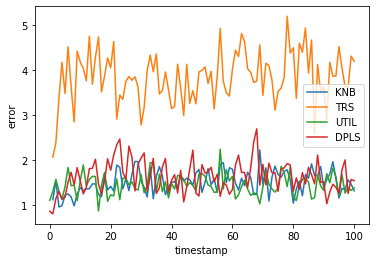

In [9]:
plt.plot(timestamps, knb_distances, label="KNB")
plt.plot(timestamps, trs_distances, label="TRS")
plt.plot(timestamps, util_distances, label="UTIL")
plt.plot(timestamps, dpls_distances, label="DPLS")
plt.xlabel("timestamp")
plt.ylabel("error")
plt.legend()
plt.show()

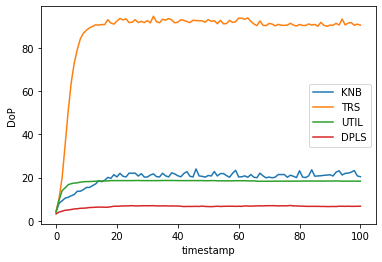

In [10]:
plt.plot(timestamps, knb_dops, label="KNB")
plt.plot(timestamps, trs_dops, label="TRS")
plt.plot(timestamps, util_dops, label="UTIL")
plt.plot(timestamps, dpls_dops, label="DPLS")
plt.xlabel("timestamp")
plt.ylabel("DoP")
plt.legend()
plt.show()